# 2 Perceptron vs Neural Networks
Student ID: 35224436 | Full name: Yiming Zhang

## Question 2 Neural Network’s Decision Boundary

### Task I

#### Load Data

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


# paths
train_path = '/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_train.csv'
test_path = '/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_test.csv'

# load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# columns
feat_cols = [c for c in train.columns if c.lower().startswith('feature')]
label_col = 'label' if 'label' in train.columns else train.columns[-1]

# map labels from {0,1} to {-1,+1}
_mapping = {0: -1, 1: 1}
if set(train[label_col].unique()) <= set(_mapping.keys()):
    train[label_col] = train[label_col].map(_mapping).astype(int)
if set(test[label_col].unique()) <= set(_mapping.keys()):
    test[label_col] = test[label_col].map(_mapping).astype(int)

labels_all = sorted(set(train[label_col]) | set(test[label_col]))

# print info
print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Columns:', list(train.columns))
print('Label values (train):', sorted(train[label_col].unique()))
print('Label values (test):', sorted(test[label_col].unique()))



Train shape: (500, 3)
Test shape: (2000, 3)
Columns: ['feature1', 'feature2', 'label']
Label values (train): [-1, 1]
Label values (test): [-1, 1]


#### Plot Function

In [187]:
def plot_train_test_scatter(train_df, test_df, feat_cols, label_col, labels_all=None):
    labels_all = sorted(set(train_df[label_col]) | set(test_df[label_col])) if labels_all is None else labels_all
    cmap = plt.get_cmap('Set3', len(labels_all))
    label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

    # helper: single panel
    def _panel(ax, df, title):
        for lab in labels_all:
            m = df[label_col] == lab
            ax.scatter(df.loc[m, feat_cols[0]], df.loc[m, feat_cols[1]],
                       color=cmap(label_to_idx[lab]), label=f'Label {lab}',
                       alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
        # (0, 0)
        ax.scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
        ax.set_title(title)
        ax.set_xlabel(feat_cols[0])
        ax.set_ylabel(feat_cols[1])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
        ax.legend(title=None)

    _panel(axs[0], train_df, 'Training data')
    _panel(axs[1], test_df, 'Testing data')
    plt.show()



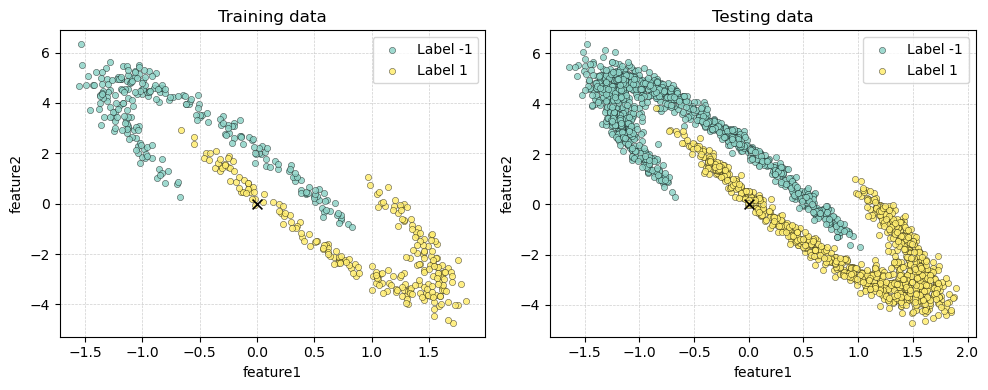

In [188]:
plot_train_test_scatter(train, test, feat_cols, label_col)

### Task II
Train two Perceptron models on the provided training data: one with early stopping and
one without.

#### Perceptron Implementation

In [189]:
class Perceptron:

    def __init__(
        self,
        eta=0.01,
        tau_max=10000,
        epsilon=0.001,
        early_stopping=False,
        threshold=0.001,
        lam=0.0,
        random_state=None,
    ):
        self.eta = eta  # learning rate
        self.tau_max = tau_max  # max number of iterations/epochs
        self.epsilon = epsilon  # tolerable training error (no ES)
        self.early_stopping = early_stopping
        self.threshold = threshold  # ES: stop if val error change < threshold
        self.lam = lam  # L2 (weight decay)
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape

        self.w_trace_ = np.empty((self.tau_max, p))  # trace of weights during training
        self.xy_idx_trace_ = np.empty(
            self.tau_max, int
        )  # trace of considered training point indices

        # initialisation of iteration counter and weights
        tau = 0
        self.w_ = self.w_trace_[0, :] = RNG.normal(size=p)

        # prepare train/val split for early stopping (20%)
        if self.early_stopping:
            idx = RNG.permutation(n)
            val_size = max(1, int(0.2 * n))
            val_idx = idx[:val_size]
            tr_idx = idx[val_size:]
            X_tr, y_tr = x[tr_idx], y[tr_idx]
            X_val, y_val = x[val_idx], y[val_idx]
        else:
            X_tr, y_tr = x, y
            X_val = y_val = None

        last_val_err = None
        terminate = False
        while not terminate:
            # random order to consider training data
            m = X_tr.shape[0]
            order = RNG.choice(np.arange(m), size=m, replace=False)
            for i in range(m):
                # L2 regularization (weight decay)
                if self.lam > 0:
                    self.w_ = self.w_ * (1 - self.eta * self.lam)

                # prediction with labels in {-1, +1}
                xi = X_tr[order][i]
                yi = y_tr[order][i]
                pred = 1 if xi.dot(self.w_) >= 0 else -1
                if pred != yi:  # perceptron update
                    self.w_ = self.w_ + self.eta * yi * xi

                # traces
                if tau + 1 < self.w_trace_.shape[0]:
                    self.w_trace_[tau + 1] = self.w_
                self.xy_idx_trace_[tau] = order[i]
                tau += 1
                if tau >= self.tau_max - 1:
                    terminate = True
                    break

            # check stopping
            if self.early_stopping and X_val is not None:
                val_pred = np.where(X_val.dot(self.w_) >= 0, 1, -1)
                val_err = (val_pred != y_val).mean()
                if last_val_err is not None and abs(last_val_err - val_err) < self.threshold:
                    terminate = True
                last_val_err = val_err
            else:
                tr_pred = np.where(X_tr.dot(self.w_) >= 0, 1, -1)
                tr_err = (tr_pred != y_tr).mean()
                if tr_err < self.epsilon:
                    terminate = True

        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau]
        self.xy_idx_trace_ = self.xy_idx_trace_[: max(0, tau - 1)]

        return self

    def predict(self, x):
        # return labels in {-1, +1}
        return np.where(x.dot(self.w_) >= 0, 1, -1)

#### Parameters Fine-tuning & Validation

In [190]:
# prepare data
X = train[feat_cols].values
Y = train[label_col].values
X_test = test[feat_cols].values
Y_test = test[label_col].values

# coercion to {-1,+1}
def to_pm1(a):
    a = np.asarray(a)
    u = set(np.unique(a))
    if u.issubset({0, 1}):
        return np.where(a == 1, 1, -1)
    return a.astype(int)

# error on test
def test_error(model, X, y):
    y_pred = to_pm1(model.predict(X))
    y_true = to_pm1(y)
    return (y_pred != y_true).mean()

etas = [0.001, 0.01, 0.1]
lams = [0.0001, 0.001, 0.01, 0.1, 1.0]

results_no_es = []
results_es = []

for eta in etas:
    for lam in lams:
        # without early stopping (train on full training set)
        m0 = Perceptron(eta=eta, lam=lam, early_stopping=False, random_state=42)
        m0.fit(X, Y)
        err0 = test_error(m0, X_test, Y_test)
        results_no_es.append({'eta': eta, 'lam': lam, 'test_err': err0, 'model': m0})

        # with early stopping (uses internal 20% validation, threshold=0.001)
        m1 = Perceptron(eta=eta, lam=lam, early_stopping=True, random_state=42)
        m1.fit(X, Y)
        err1 = test_error(m1, X_test, Y_test)
        results_es.append({'eta': eta, 'lam': lam, 'test_err': err1, 'model': m1})

# select best
best_no_es = min(results_no_es, key=lambda r: r['test_err'])
best_es = min(results_es, key=lambda r: r['test_err'])

print('No Early stopping best:', {'eta': best_no_es['eta'], 'lam': best_no_es['lam'], 'test_err': best_no_es['test_err']})
print('Early stopping best:', {'eta': best_es['eta'], 'lam': best_es['lam'], 'test_err': best_es['test_err']})

# summary tables
_df_no_es = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_no_es]).sort_values('test_err').reset_index(drop=True)
_df_es = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_es]).sort_values('test_err').reset_index(drop=True)

display(_df_no_es)
display(_df_es)
best_model_no_es = best_no_es['model']
best_model_es = best_es['model']



No Early stopping best: {'eta': 0.001, 'lam': 1.0, 'test_err': 0.1285}
Early stopping best: {'eta': 0.001, 'lam': 0.0001, 'test_err': 0.1285}


,eta,lam,test_err
0,0.001,1.0000,0.1285
1,0.001,0.0010,0.1290
2,0.010,0.0010,0.1290
3,0.010,0.0100,0.1290
4,0.100,0.0100,0.1295
5,0.001,0.0100,0.1330
6,0.001,0.0001,0.1370
7,0.010,1.0000,0.1380
8,0.100,0.1000,0.1380
9,0.010,0.1000,0.1385


,eta,lam,test_err
0,0.001,0.0001,0.1285
1,0.001,0.0010,0.1285
2,0.001,0.0100,0.1285
3,0.001,0.1000,0.1285
4,0.001,1.0000,0.1285
5,0.010,0.0100,0.1285
6,0.010,1.0000,0.1285
7,0.100,1.0000,0.1285
8,0.100,0.0010,0.1310
9,0.010,0.1000,0.1315


#### Plot Function
Plot showing the best models with and without early stopping and their decision boundaries

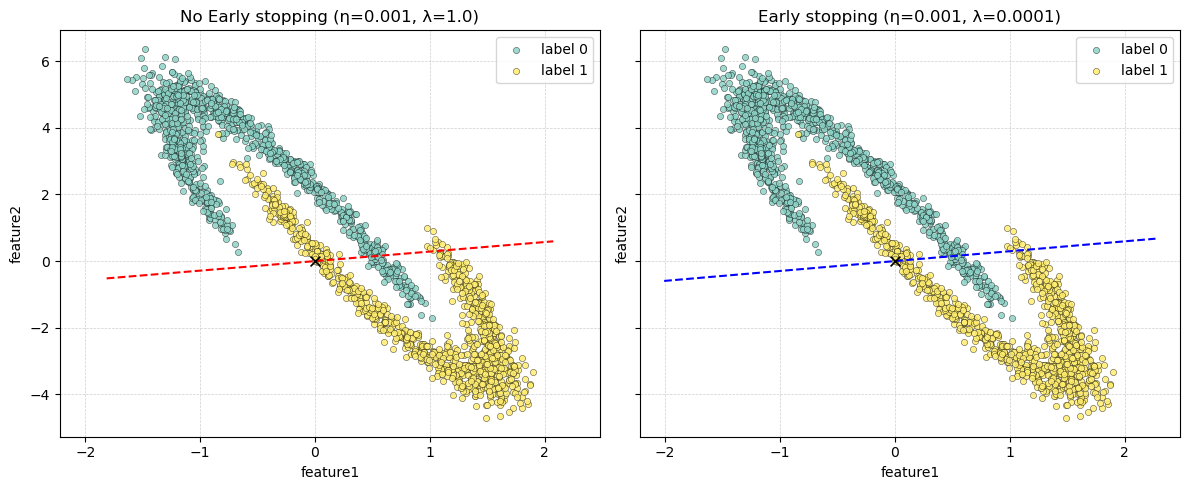

In [191]:
# liner decision boundary (x2 = -(w1/w2) * x1)
def plot_line_from_w(ax, w, color):
    if abs(w[1]) < 1e-12:
        ax.plot([0, 0], ax.get_ylim(), linestyle='--', color=color, label='_nolegend_')
    else:
        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 200)
        y = -(w[0] / w[1]) * x
        ax.plot(x, y, linestyle='--', color=color, label='_nolegend_')

labels_all = sorted(test[label_col].unique())  # {-1,+1}
lab_name = { -1: 'label 0', 1: 'label 1' }
cmap = plt.get_cmap('Set3', len(labels_all))
label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True, sharex=True, sharey=True)

# Left: No Early stopping
for lab in labels_all:
    m = test[label_col] == lab
    axs[0].scatter(test.loc[m, feat_cols[0]], test.loc[m, feat_cols[1]],
                   color=cmap(label_to_idx[lab]), label=lab_name.get(lab, str(lab)),
                   alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
axs[0].scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
axs[0].set_title(f'No Early stopping (η={best_no_es["eta"]}, λ={best_no_es["lam"]})')
axs[0].set_xlabel(feat_cols[0])
axs[0].set_ylabel(feat_cols[1])
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plot_line_from_w(axs[0], best_model_no_es.w_, color='red')
axs[0].legend(title=None)

# Right: Early stopping
for lab in labels_all:
    m = test[label_col] == lab
    axs[1].scatter(test.loc[m, feat_cols[0]], test.loc[m, feat_cols[1]],
                   color=cmap(label_to_idx[lab]), label=lab_name.get(lab, str(lab)),
                   alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
axs[1].scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
axs[1].set_title(f'Early stopping (η={best_es["eta"]}, λ={best_es["lam"]})')
axs[1].set_xlabel(feat_cols[0])
axs[1].set_ylabel(feat_cols[1])
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plot_line_from_w(axs[1], best_model_es.w_, color='blue')
axs[1].legend(title=None)

plt.show()



### Task III

#### Neural Nwtwork Implementation (3 layers)

In [192]:
class ThreeLayerNN:

    def __init__(
        self, hidden_size=5, eta=0.1, lam=1e-4, epoch_max=1000, random_state=None
    ):
        self.hidden_size = int(hidden_size)
        self.eta = float(eta)
        self.lam = float(lam)
        self.epoch_max = int(epoch_max)
        self.random_state = random_state
        self.train_accuracy_ = []

    # auxiliary functions
    def h(self, z):
        return 1 / (1 + np.exp(-3 * z))

    def h_d(self, z):
        return 3 * (self.h(z) * (1 - self.h(z)))

    def accuracy(self, pred, label):
        return (pred == label).mean()

    def _init_params(self, D, K):
        ## weight vectors/matrices initialization
        ### w stands for weight and b for bias
        ### the number after the letters indicates the layer number
        rng = np.random.default_rng(self.random_state)
        self.W1_ = rng.normal(scale=0.5, size=(D, K))
        self.b1_ = np.zeros((1, K))
        self.W2_ = rng.normal(scale=0.5, size=(K, 1))
        self.b2_ = np.zeros((1, 1))

    def feedforward(self, Xi, Ti, W1, b1, W2, b2):
        a1 = Xi
        y = Ti
        z2 = a1 @ W1 + b1
        a2 = self.h(z2)
        z3 = a2 @ W2 + b2
        a3 = self.h(z3)
        return (a1, a2, a3, y, z2, z3)

    def backpropagation(self, Ti, W2, z2, z3, a3):
        d3 = -(Ti - a3) * self.h_d(z3)
        d2 = (d3 @ W2.T) * self.h_d(z2)
        return (d2, d3)

    def prediction(self, X, W1=None, W2=None, b1=None, b2=None, threshold=0.5):
        if W1 is None:
            W1 = self.W1_
        if W2 is None:
            W2 = self.W2_
        if b1 is None:
            b1 = self.b1_
        if b2 is None:
            b2 = self.b2_
        # we use the feedforward network we defined to obtain output activation (a3), we don't care about the
        _, _, a3, _, _, _ = self.feedforward(X, 1, W1, b1, W2, b2)
        return np.array(
            [1 if above_thresh else 0 for above_thresh in (a3 >= threshold)]
        ).reshape(-1, 1)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).reshape(-1, 1)

        N, D = X.shape
        K = self.hidden_size
        self._init_params(D, K)

        self.train_accuracy_.clear()
        epoch = 1
        terminate = False
        # training loop
        while not terminate:
            ## Feedforward:
            a1, a2, a3, y, z2, z3 = self.feedforward(
                X, y, self.W1_, self.b1_, self.W2_, self.b2_
            )

            ## Backpropagation:
            d2, d3 = self.backpropagation(y, self.W2_, z2, z3, a3)

            ## calculate the delta values
            ### 1st layer
            W1_d = a1.T @ d2
            b1_d = d2
            ### 2nd layer
            W2_d = a2.T @ d3
            b2_d = d3

            ## update weight vectors and matrices
            ### 1st (input) layer
            self.W1_ = self.W1_ - self.eta * (W1_d / N + self.lam * self.W1_)
            self.b1_ = self.b1_ - self.eta * (b1_d.mean(axis=0, keepdims=True))
            ### 2nd (hidden) layer
            self.W2_ = self.W2_ - self.eta * (W2_d / N + self.lam * self.W2_)
            self.b2_ = self.b2_ - self.eta * (b2_d.mean(axis=0, keepdims=True))

            ## trace train  and test accuracy
            self.train_accuracy_.append(
                self.accuracy(
                    self.prediction(X, self.W1_, self.W2_, self.b1_, self.b2_), y
                )
            )

            epoch += 1
            if epoch > self.epoch_max:
                terminate = True

        return self

#### Parameters Fine-tuning & Validation

In [193]:
# Grid search: λ ∈ {0.001, 1.0}, K ∈ {5..40 step 5}, η ∈ {0.001, 0.01, 0.1}
X_tr = train[feat_cols].values
Y_tr = (train[label_col].values == 1).reshape(-1, 1).astype(int)
X_te = test[feat_cols].values
Y_te = (test[label_col].values == 1).reshape(-1, 1).astype(int)

lams = [0.001, 1.0]
K_list = list(range(5, 41, 5))  # [5, 10, 15, 20, 25, 30, 35, 40]
etas = [0.001, 0.01, 0.1]

results = []
best_by_lam = {}

for lam in lams:
    print(f"\n=== λ = {lam} ===")
    best = None
    for K in K_list:
        for eta in etas:
            model = ThreeLayerNN(hidden_size=K, eta=eta, lam=lam, random_state=1)
            model.fit(X_tr, Y_tr)
            y_pred = model.prediction(X_te)
            test_err = (y_pred.ravel() != Y_te.ravel()).mean()
            results.append({'lam': lam, 'K': K, 'eta': eta, 'test_err': float(test_err), 'model': model})
            print(f"K={K:2d}, η={eta:<6} -> test_err={test_err:.4f}")
            if (best is None) or (test_err < best['test_err']):
                best = {'lam': lam, 'K': K, 'eta': eta, 'test_err': float(test_err), 'model': model}
    best_by_lam[lam] = best
    print(f"Best @ λ={lam}: K={best['K']}, η={best['eta']}, test_err={best['test_err']:.4f}")

# Summary results table (remove model objects for display)
res_df = pd.DataFrame([{k:v for k,v in r.items() if k!='model'} for r in results])
res_df = res_df.sort_values(['lam','test_err','K','eta']).reset_index(drop=True)
display(res_df)

# Save best models for plotting
best_lam_0001 = best_by_lam.get(0.001)
best_lam_1p0  = best_by_lam.get(1.0)

# Formatted summary of best configurations
print("\n" + "="*60)
print("SUMMARY OF BEST CONFIGURATIONS")
print("="*60)
print(f"\nλ = 0.001:")
print(f"  - Best K:        {best_lam_0001['K']}")
print(f"  - Best eta:      {best_lam_0001['eta']}")
print(f"  - Test error:    {best_lam_0001['test_err']:.4f}")
print(f"\nλ = 1.0:")
print(f"  - Best K:        {best_lam_1p0['K']}")
print(f"  - Best eta:      {best_lam_1p0['eta']}")
print(f"  - Test error:    {best_lam_1p0['test_err']:.4f}")
print("\n" + "="*60)




=== λ = 0.001 ===
K= 5, η=0.001  -> test_err=0.1330
K= 5, η=0.01   -> test_err=0.1265
K= 5, η=0.1    -> test_err=0.1215
K=10, η=0.001  -> test_err=0.1990
K=10, η=0.01   -> test_err=0.1235
K=10, η=0.1    -> test_err=0.1155
K=15, η=0.001  -> test_err=0.1345
K=15, η=0.01   -> test_err=0.1200
K=15, η=0.1    -> test_err=0.1185
K=20, η=0.001  -> test_err=0.1355
K=20, η=0.01   -> test_err=0.1225
K=20, η=0.1    -> test_err=0.1190
K=25, η=0.001  -> test_err=0.1305
K=25, η=0.01   -> test_err=0.1200
K=25, η=0.1    -> test_err=0.1010
K=30, η=0.001  -> test_err=0.1425
K=30, η=0.01   -> test_err=0.1200
K=30, η=0.1    -> test_err=0.1020
K=35, η=0.001  -> test_err=0.1495
K=35, η=0.01   -> test_err=0.1245
K=35, η=0.1    -> test_err=0.0745
K=40, η=0.001  -> test_err=0.1275
K=40, η=0.01   -> test_err=0.1140
K=40, η=0.1    -> test_err=0.0685
Best @ λ=0.001: K=40, η=0.1, test_err=0.0685

=== λ = 1.0 ===
K= 5, η=0.001  -> test_err=0.1300
K= 5, η=0.01   -> test_err=0.5000
K= 5, η=0.1    -> test_err=0.5000
K

,lam,K,eta,test_err
0,0.001,40,0.100,0.0685
1,0.001,35,0.100,0.0745
2,0.001,25,0.100,0.1010
3,0.001,30,0.100,0.1020
4,0.001,40,0.010,0.1140
5,0.001,10,0.100,0.1155
6,0.001,15,0.100,0.1185
7,0.001,20,0.100,0.1190
8,0.001,15,0.010,0.1200
9,0.001,25,0.010,0.1200



SUMMARY OF BEST CONFIGURATIONS

λ = 0.001:
  - Best K:        40
  - Best eta:      0.1
  - Test error:    0.0685

λ = 1.0:
  - Best K:        30
  - Best eta:      0.001
  - Test error:    0.1210



#### Plot Function


/var/folders/91/nm6sfn91479cd_p42v7bj7_h0000gn/T/ipykernel_69534/1281598605.py:23: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, zz, levels=[0.5], colors=boundary_color, linewidths=1.0, linestyles='--', label='_nolegend_')


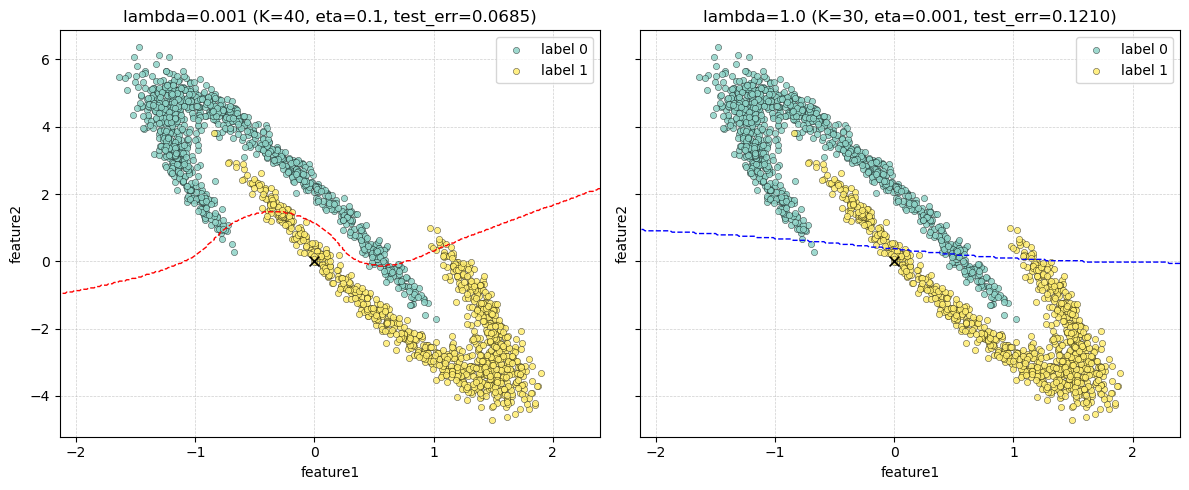

In [194]:
# Plot decision boundaries (matching Task II style exactly)
# Reuse Task II styling
labels_all_nn = sorted(np.unique(Y_te.ravel()))  # {0, 1}
lab_name_nn = {0: 'label 0', 1: 'label 1'}
cmap_nn = plt.get_cmap('Set3', len(labels_all_nn))
label_to_idx_nn = {lab: i for i, lab in enumerate(labels_all_nn)}

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True, sharex=True, sharey=True)

# Helper function to plot NN decision boundary
def plot_nn_boundary(ax, model, boundary_color, title):
    # Grid for decision boundary
    x_min = X_te[:, 0].min() - 0.5
    x_max = X_te[:, 0].max() + 0.5
    y_min = X_te[:, 1].min() - 0.5
    y_max = X_te[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.prediction(grid).ravel().reshape(xx.shape)
    
    # Decision boundary line (dashed)
    ax.contour(xx, yy, zz, levels=[0.5], colors=boundary_color, linewidths=1.0, linestyles='--', label='_nolegend_')
    
    # Test data scatter (same style as Task II)
    for lab in labels_all_nn:
        m = (Y_te.ravel() == lab)
        ax.scatter(X_te[m, 0], X_te[m, 1],
                   color=cmap_nn(label_to_idx_nn[lab]),
                   label=lab_name_nn.get(lab, str(lab)),
                   alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
    
    ax.scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
    ax.set_title(title)
    ax.set_xlabel(feat_cols[0])
    ax.set_ylabel(feat_cols[1])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(title=None)

# Left: lambda=0.001
plot_nn_boundary(axs[0], best_lam_0001['model'], boundary_color='red',
                 title=f"lambda=0.001 (K={best_lam_0001['K']}, eta={best_lam_0001['eta']}, test_err={best_lam_0001['test_err']:.4f})")

# Right: lambda=1.0
plot_nn_boundary(axs[1], best_lam_1p0['model'], boundary_color='blue',
                 title=f"lambda=1.0 (K={best_lam_1p0['K']}, eta={best_lam_1p0['eta']}, test_err={best_lam_1p0['test_err']:.4f})")

plt.show()


#### Explanation

From the results, The 3-layer neural network with $\lambda=0.001$, K = 40, and $\eta=0.1$ performs better.
Its lower regularisation strength allows the model to learn a non-linear decision boundary that fits the complex structure of the data, achieving lower test error (0.0685).
The model with λ = 1.0 is over-regularised — its boundary becomes nearly linear, limiting learning capacity and leading to underfitting.



### Task IV

#### Differences

For **Perceptron models** (both with and without early stopping) show a straight-line decision boundary, which cleanly separates the two classes only in roughly linear regions.

For *3-layer neural networks*, especially with smaller regularisation ($\lambda=0.001$), produce a curved, non-linear boundary that follows the true data distribution more closely.

However, when $\lambda=1.0$ (stronger regularisation), the NN’s boundary becomes almost linear again, showing underfitting.

#### Reasons

The main reason for the difference between the Perceptron and Neural Network comes from their underlying principles and representational power.

The Perceptron follows a linear model, computing a weighted sum of inputs followed by a step activation function $f(x) = \text{sign}(w^T x + b)$. This means it can only form a linear decision boundary, separating data with a single hyperplane. Once the data are not linearly separable, the Perceptron cannot correctly classify them regardless of how it is trained.

In contrast, the Neural Network introduces hidden layers and non-linear activation functions (e.g., Sigmoid, ReLU or tanh), which allow it to perform multiple linear transformations and non-linear mappings in sequence. This hierarchical composition enables the network to approximate non-linear decision surfaces, effectively capturing the complex structure of the data.

Therefore, in the plots, the Perceptron produces a straight-line boundary, while the Neural Network learns a smooth, curved boundary that fits the data distribution more accurately. 

The smaller regularisation (λ=0.001) further allows the NN to fully utilise its non-linear capacity, whereas stronger regularisation (λ=1.0) constrains its weights, forcing it to behave more like a linear model and resulting in underfitting.